# 모델링
Catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action = 'ignore')

from scipy.spatial import distance
from math import log2
from math import sqrt
from sklearn.cluster import AgglomerativeClustering

!pip install bayesian-optimization

from sklearn.model_selection import KFold,StratifiedKFold   # K-fold CV 
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import mean_squared_log_error

import warnings
warnings.filterwarnings(action = 'ignore')

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import RobustScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=0d14e28b7b694782d37a3543390d2c8032a76240fa94eac7e8735cfcfb6a2010
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 144579 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


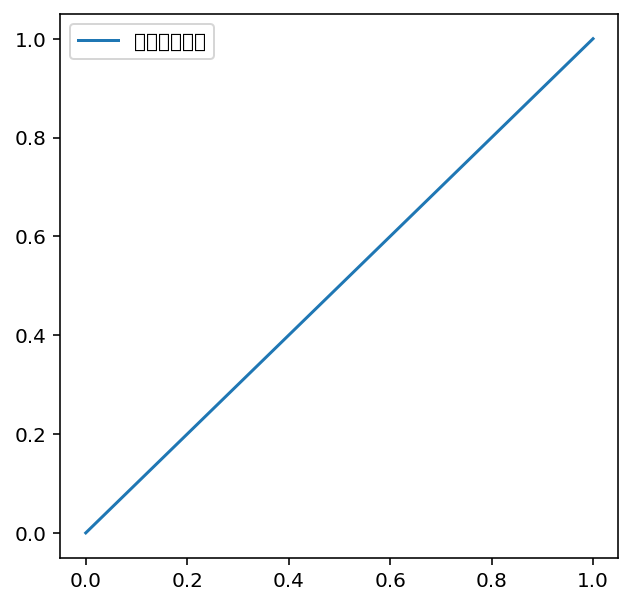

In [ ]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()

In [ ]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/빅청캠/df_boosting.csv')
df.head()

,도시,공사,modified공종명,설계수량,공구별면적,주거면적,주거면적(%),공구별세대수,기간(월),이상치,hdb_clusters,hdb_mean,hdb_std,도-단cluster,공-단cluster,도공-단cluster,도-단비cluster,공-단비cluster,도공-단비cluster,도-수비cluster,공-수비cluster,도공-수비cluster,도-단clustermean,도-단clusterstd,공-단clustermean,공-단clusterstd,도공-단clustermean,도공-단clusterstd,도-단비clustermean,도-단비clusterstd,공-단비clustermean,공-단비clusterstd,도공-단비clustermean,도공-단비clusterstd,도-수비clustermean,도-수비clusterstd,공-수비clustermean,공-수비clusterstd,도공-수비clustermean,도공-수비clusterstd,도급단가합계
0,광교1,구조물공사,강관파일기초,7337.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,254,383301.857143,485940.558325,17,6,9,2,22,74,22,3,80,1.936300e+06,1.235332e+07,318080.400000,608002.829725,586871.333333,705899.572921,905478.762774,2.400655e+06,318080.400000,608002.829725,817921.500000,822364.479413,1.015044e+06,2.455870e+06,124222.157895,318363.549917,817921.500000,822364.479413,1399421.0
1,광교1,구조물공사,되메우기및다짐,8973.0,1067184.0,604873.6,56.67941,9177.0,43.0,0,292,9276.842105,10462.150381,407,372,500,444,543,631,479,607,303,8.410143e+03,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,8410.142857,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,8.410143e+03,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,1395.0
2,광교1,구조물공사,뒷채움부설및다짐,1558.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,1019,10549.523810,14778.036032,520,415,253,625,416,423,595,439,503,4.952800e+03,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,4952.800000,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,4.952800e+03,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,2878.0
3,광교1,구조물공사,보강토옹벽,402.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,260,163376.000000,103302.643877,17,678,9,2,369,74,22,3,80,1.936300e+06,1.235332e+07,236422.000000,NaN,586871.333333,705899.572921,905478.762774,2.400655e+06,236422.000000,NaN,817921.500000,822364.479413,1.015044e+06,2.455870e+06,124222.157895,318363.549917,817921.500000,822364.479413,236422.0
4,광교1,구조물공사,식생옹벽블럭,341.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,265,30559.428571,47851.742577,17,672,9,2,311,338,504,3,204,1.936300e+06,1.235332e+07,124771.000000,NaN,586871.333333,705899.572921,905478.762774,2.400655e+06,124771.000000,NaN,124771.000000,NaN,1.247710e+05,NaN,124222.157895,318363.549917,124771.000000,NaN,124771.0


In [ ]:
df = df[df['도급단가합계']>0]
df = df.reset_index(drop=True)
df.head()

,도시,공사,modified공종명,설계수량,공구별면적,주거면적,주거면적(%),공구별세대수,기간(월),이상치,hdb_clusters,hdb_mean,hdb_std,도-단cluster,공-단cluster,도공-단cluster,도-단비cluster,공-단비cluster,도공-단비cluster,도-수비cluster,공-수비cluster,도공-수비cluster,도-단clustermean,도-단clusterstd,공-단clustermean,공-단clusterstd,도공-단clustermean,도공-단clusterstd,도-단비clustermean,도-단비clusterstd,공-단비clustermean,공-단비clusterstd,도공-단비clustermean,도공-단비clusterstd,도-수비clustermean,도-수비clusterstd,공-수비clustermean,공-수비clusterstd,도공-수비clustermean,도공-수비clusterstd,도급단가합계
0,광교1,구조물공사,강관파일기초,7337.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,254,383301.857143,485940.558325,17,6,9,2,22,74,22,3,80,1.936300e+06,1.235332e+07,318080.400000,608002.829725,586871.333333,705899.572921,905478.762774,2.400655e+06,318080.400000,608002.829725,817921.500000,822364.479413,1.015044e+06,2.455870e+06,124222.157895,318363.549917,817921.500000,822364.479413,1399421.0
1,광교1,구조물공사,되메우기및다짐,8973.0,1067184.0,604873.6,56.67941,9177.0,43.0,0,292,9276.842105,10462.150381,407,372,500,444,543,631,479,607,303,8.410143e+03,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,8410.142857,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,8.410143e+03,6.149926e+03,8410.142857,6149.926039,8410.142857,6149.926039,1395.0
2,광교1,구조물공사,뒷채움부설및다짐,1558.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,1019,10549.523810,14778.036032,520,415,253,625,416,423,595,439,503,4.952800e+03,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,4952.800000,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,4.952800e+03,1.160361e+03,4952.800000,1160.361452,4952.800000,1160.361452,2878.0
3,광교1,구조물공사,보강토옹벽,402.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,260,163376.000000,103302.643877,17,678,9,2,369,74,22,3,80,1.936300e+06,1.235332e+07,236422.000000,NaN,586871.333333,705899.572921,905478.762774,2.400655e+06,236422.000000,NaN,817921.500000,822364.479413,1.015044e+06,2.455870e+06,124222.157895,318363.549917,817921.500000,822364.479413,236422.0
4,광교1,구조물공사,식생옹벽블럭,341.0,1067184.0,604873.6,56.67941,9177.0,43.0,1,265,30559.428571,47851.742577,17,672,9,2,311,338,504,3,204,1.936300e+06,1.235332e+07,124771.000000,NaN,586871.333333,705899.572921,905478.762774,2.400655e+06,124771.000000,NaN,124771.000000,NaN,1.247710e+05,NaN,124222.157895,318363.549917,124771.000000,NaN,124771.0


In [ ]:
# train, test 나누기

train_df = df[df['도시'] != '동탄5']
test_df = df[df['도시'] == '동탄5']

In [ ]:
X_train=train_df.drop('도급단가합계',axis=1)
y_train=train_df['도급단가합계']
y_train = np.log1p(y_train)


X_test=test_df.drop('도급단가합계',axis=1)
y_test=test_df['도급단가합계']

#공구명 삭제
X_train.drop('도시',axis=1,inplace=True)
X_test.drop('도시',axis=1,inplace=True)

# X_train=train_df.drop('도급합계금액',axis=1)
# y_train=train_df['도급합계금액']
# X_test=test_df.drop('도급합계금액',axis=1)
# y_test=test_df['도급합계금액']

# #공구명 삭제
# X_train.drop('도시',axis=1,inplace=True)
# X_test.drop('도시',axis=1,inplace=True)

## Catboost

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 66.1MB 47kB/s 


In [ ]:
cat_features = ['공사', 'modified공종명','hdb_clusters', '도-단cluster', '공-단cluster', '도공-단cluster','도-단비cluster', '공-단비cluster', '도공-단비cluster', '도-수비cluster','공-수비cluster', '도공-수비cluster']

### 베이지안 최적화

In [ ]:
def cat_cv(learning_rate,iterations,max_ctr_complexity, x_data=None, y_data=None, n_splits=5, output='model'):
    score = 0
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=201)
    models = []
    for train_index, valid_index in skf.split(x_data,x_data['hdb_clusters']):
       #print(train_index)
       x_train, y_train = x_data.iloc[train_index], y_data.iloc[train_index]
       x_valid, y_valid = x_data.iloc[valid_index], y_data.iloc[valid_index]
        
       model = CatBoostRegressor(
           task_type="GPU",
           learning_rate = learning_rate,
           iterations = int(iterations),
           max_ctr_complexity = int(max_ctr_complexity),
           )
       
       model.fit(x_train, y_train,cat_features=cat_features,silent=True)
       models.append(model)
        
       pred = model.predict(x_valid)
       true = y_valid
       mse =  mean_squared_error(true,pred)*(-1)
       mae = mean_absolute_error(true, pred)*(-1)
       R2 = r2_score(true, pred)
       #msle=mean_squared_log_error(true, pred)*(-1)
       score += mse/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [ ]:
func_fixed = partial(cat_cv, x_data=X_train, y_data=y_train, n_splits=5, output='score') 

catBO = BayesianOptimization(
    func_fixed, 
    {
        'learning_rate': (0.01, 0.1),
        'iterations':(1000,3000),
        'max_ctr_complexity':(10,16),
    }, 
    random_state=4321
)
catBO.maximize(init_points=20, n_iter=5) #30

|   iter    |  target   | iterat... | learni... | max_ct... |
-------------------------------------------------------------
|  1        | -1.236    |  1.142e+0 |  0.08336  |  14.61    |
|  2        | -1.27     |  1.573e+0 |  0.02738  |  15.87    |
|  3        | -1.222    |  1.812e+0 |  0.0782   |  10.53    |


In [ ]:
params = catBO.max['params']
models = cat_cv(   
    params['learning_rate'],
    params['iterations'],
    params['max_ctr_complexity'], 
    x_data=X_train, y_data=y_train, n_splits=5, output='model')

In [ ]:
preds = []
for model in models:
    pred = model.predict(X_train)
    preds.append(pred)

pred = np.mean(preds, axis=0)

In [ ]:
#mean_absolute_error(y_train,pred)
mean_squared_error(np.expm1(y_train), np.expm1(pred))**0.5

In [ ]:
#r2_score(y_train, pred)
r2_score(np.expm1(y_train), np.expm1(pred))

In [ ]:
preds = []
for model in models:
    pred = model.predict(X_test)
    preds.append(pred)

pred = np.mean(preds, axis=0)

In [ ]:
#mean_absolute_error(y_test,pred)
mean_squared_error(y_test,np.expm1(pred))**0.5

In [ ]:
#r2_score(y_train, pred)
r2_score(y_test, np.expm1(pred))

In [ ]:
np.expm1(pred).sum() - y_test.sum()